# Dense Retrieval Passage for Open Domain Question & Answering
Submitted by: Rishabh Kaushick

# 1. Environment Setup

In [1]:
%pip install --quiet torch transformers

Note: you may need to restart the kernel to use updated packages.


If on GPU:

In [2]:
%pip install --quiet faiss-gpu

Note: you may need to restart the kernel to use updated packages.


If on CPU:

In [ ]:
%pip install --quiet faiss-cpu

In [3]:
# installing datasets (hugging face dataset library)
%pip install --quiet datasets

Note: you may need to restart the kernel to use updated packages.


Restarting the kernel as suggested.

In [4]:
%reset

In [5]:
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset, load_from_disk
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import faiss
import json
import random

## CUDA: GPU Availability

In [6]:
 
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available: {torch.cuda.is_available()}")
 
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"cuDNN enabled: {torch.backends.cudnn.enabled}")
    print(f"GPU Count: {torch.cuda.device_count()}")
    
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
        print(f"Memory Reserved: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")
 
else:
    print("CUDA is not available. Running on CPU.")

PyTorch version: 2.2.1+cu121
Is CUDA available: True
CUDA version: 12.1
cuDNN version: 8902
cuDNN enabled: True
GPU Count: 1
GPU 0: NVIDIA L4
Memory Allocated: 0.00 MB
Memory Reserved: 0.00 MB


# 2. Dataset Selection and Exploration (15%)

## Loading Dataset (from HuggingFace)

### Download Training Set

In [ ]:
dataset = load_dataset("ms_marco", "v2.1", split="train[:15000]")

### Saving Training Set to Disk

In [ ]:
# need to save the dataset in /data/train
dataset.save_to_disk("./data/train/ms_marco_15k")

### Loading Train Set from Disk

In [7]:
# https://huggingface.co/docs/datasets/v3.3.2/en/package_reference/main_classes#datasets.Dataset.save_to_disk

# load the already saved dataset from the disk
dataset = load_from_disk("./data/train/ms_marco_15k")

In [8]:
print(len(dataset))

15000


### Loading & Saving Validation Set

In [8]:
validation_dataset = load_dataset("ms_marco", "v2.1", split="validation[:10000]")

In [ ]:
# save validation dataset
validation_dataset.save_to_disk("./data/validation/ms_marco")

In [9]:
validation_dataset = load_from_disk("./data/validation/ms_marco")

In [10]:
len(validation_dataset)

10000

### Loading & Saving Test Set

In [12]:
test_dataset = load_dataset("ms_marco", "v2.1", split="test[:10000]")

In [ ]:
# save test dataset to the disk
test_dataset.save_to_disk("./data/test/ms_marco")

In [11]:
test_dataset = load_from_disk("./data/test/ms_marco")

In [12]:
len(test_dataset)

10000

## Exploratory Data Analysis

In [13]:
dataset

Dataset({
    features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
    num_rows: 15000
})

In [14]:
type(dataset)

datasets.arrow_dataset.Dataset

Since the above is a different datatype for the dataset, for convenience, I am converting this to pandas DataFrame.

In [15]:
train_df = dataset.data.to_pandas()
train_df.head()

,answers,passages,query,query_id,query_type,wellFormedAnswers
0,[The immediate impact of the success of the ma...,"{'is_selected': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",)what was the immediate impact of the success ...,1185869,DESCRIPTION,[]
1,[Restorative justice that fosters dialogue bet...,"{'is_selected': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]...",_________ justice is designed to repair the ha...,1185868,DESCRIPTION,[]
2,[The reasons why Stalin wanted to control East...,"{'is_selected': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]...",why did stalin want control of eastern europe,1185854,DESCRIPTION,[]
3,[Nails rust in water because water allows the ...,"{'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]...",why do nails get rusty,1185755,DESCRIPTION,[]
4,"[Depona Ab is a library in Vilhelmina, Sweden.]","{'is_selected': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]...",depona ab,1184773,DESCRIPTION,[]


### Query & Answers (Examples)

In [16]:
train_df[['query', 'answers']].tail()

,query,answers
14995,what is a traditional breakfast food in chile,[Fresh bread (pan amasado) with fruit jellies ...
14996,what are the colors of a croton flower,"[Originally croton leaves are green, but it ch..."
14997,what is ce with a medical device,[CE Marking is a mandatory requirement for med...
14998,were ancient iberians an ethnic group?,[The Iberians were not a ethnic group.]
14999,what is a nanofiller,[No Answer Present.]


### Data & Data types

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   answers            15000 non-null  object
 1   passages           15000 non-null  object
 2   query              15000 non-null  object
 3   query_id           15000 non-null  int32 
 4   query_type         15000 non-null  object
 5   wellFormedAnswers  15000 non-null  object
dtypes: int32(1), object(5)
memory usage: 644.7+ KB


#### Query ID 

In [18]:
train_df['query_id'].nunique()

15000

In [19]:
train_df.describe()

,query_id
count,1.500000e+04
mean,5.317663e+05
std,2.870053e+05
min,9.900000e+01
25%,3.797632e+05
50%,5.198510e+05
75%,6.633990e+05
max,1.185869e+06


Based on the statistical distribution above the Query ID column has values ranging from 99 to ~1.2 million. Therefore int32 is the smallest and most optimal datatype for this column. 


#### Query Type

In [20]:
train_df['query_type'].unique()

array(['DESCRIPTION', 'LOCATION', 'NUMERIC', 'ENTITY', 'PERSON'],
      dtype=object)

In [21]:
query_type_counts = train_df['query_type'].value_counts()
query_type_counts

query_type
DESCRIPTION    9344
NUMERIC        3232
ENTITY         1392
LOCATION        632
PERSON          400
Name: count, dtype: int64

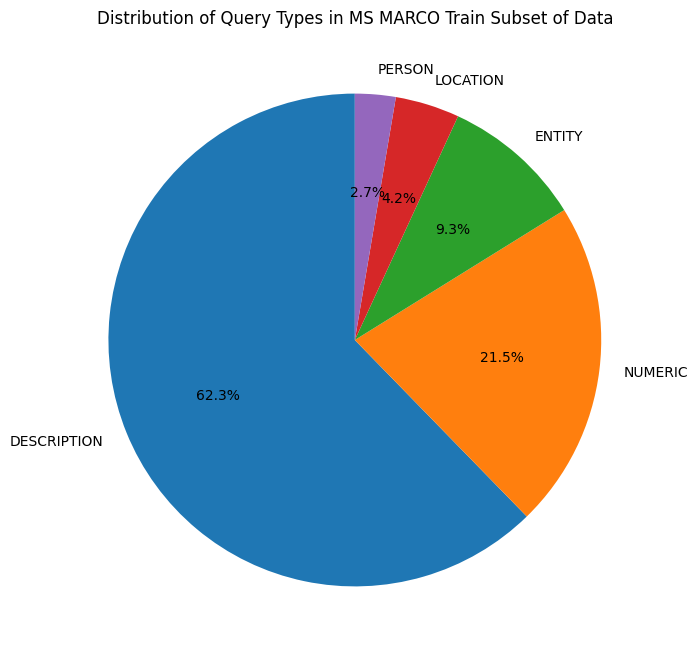

In [22]:
# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(query_type_counts.values, 
        labels=query_type_counts.index, 
        autopct='%1.1f%%', 
        startangle=90)

plt.title('Distribution of Query Types in MS MARCO Train Subset of Data')

plt.show()

Let's look at different query types:

In [23]:
# query type: DESCRIPTION
train_df.query("query_type == 'DESCRIPTION'")[['query', 'answers', 'wellFormedAnswers']]

,query,answers,wellFormedAnswers
0,)what was the immediate impact of the success ...,[The immediate impact of the success of the ma...,[]
1,_________ justice is designed to repair the ha...,[Restorative justice that fosters dialogue bet...,[]
2,why did stalin want control of eastern europe,[The reasons why Stalin wanted to control East...,[]
3,why do nails get rusty,[Nails rust in water because water allows the ...,[]
4,depona ab,"[Depona Ab is a library in Vilhelmina, Sweden.]",[]
...,...,...,...
14992,minimalism meaning,[Minimalism is a movement in sculpture and pai...,[]
14994,what does motd stand for in terraria,[No Answer Present.],[]
14997,what is ce with a medical device,[CE Marking is a mandatory requirement for med...,[]
14998,were ancient iberians an ethnic group?,[The Iberians were not a ethnic group.],[]


In [24]:
# query type: LOCATION
train_df.query("query_type == 'LOCATION'")[['query', 'answers', 'wellFormedAnswers']]

,query,answers,wellFormedAnswers
5,is the atlanta airport the busiest in the world,[No Answer Present.],[]
18,what county is dewitt michigan in?,"[DeWitt is located in Clinton County, Michigan...",[]
23,what county is columbus city in,[Bartholomew],[Columbus is a city in Bartholomew County.]
26,"what county is shelton, ct","[Shelton is in Fairfield County, Connecticut, ...",[]
42,what county is seminole fl in,[Pinellas County],"[Seminole, Florida is in Pinellas County.]"
...,...,...,...
14872,is dubai a world city,[Yes],[]
14945,"what county is hazelwood, pa located",[Allegheny County],[]
14947,what county is louin ms in,[Jasper County],"[Louin is located in Jasper County, Mississippi.]"
14959,mindbodygreen address,[No Answer Present.],[]


In [25]:
# query type: NUMERIC
train_df.query("query_type == 'NUMERIC'")[['query', 'answers', 'wellFormedAnswers']]

,query,answers,wellFormedAnswers
6,nyu tuition cost,"[$43,746 for the 2014-2015 academic year.]",[]
7,at what age do kids start to hold memories,[Before the age of 2–4 years.],[]
8,average teeth brushing time,[Americans brush for just under the two minute...,[]
12,artin chicken mcdonalds calories,[No Answer Present.],[]
15,sum of squares of even numbers formula,[No Answer Present.],[]
...,...,...,...
14971,what % of your body weight should be water,[The amount of water in the human body ranges ...,[]
14972,how much caffeine is in green coffee,[20 mg],[There is 20 mg of caffeine in green coffee.]
14975,how far is secrets punta cana from the airport,[No Answer Present.],[]
14986,planting distance for blue plumbago,[36 to 60 inches apart],[The planting distance for blue plumbago 36 to...


In [26]:
# query type: ENTITY
train_df.query("query_type == 'ENTITY'")[['query', 'answers', 'wellFormedAnswers']]

,query,answers,wellFormedAnswers
21,what is early bird check in southwest,[It allows passengers to check-in to a flight ...,[]
46,what is home food store,[No Answer Present.],[]
60,is the cheetah an endangered species,"[Yes, Cheetah is considered Endangered species.]",[]
69,Niegerian Prophet turns into a snake in church...,[No Answer Present.],[]
72,what are signs of ulcers in equine,[No Answer Present.],[]
...,...,...,...
14952,what dog breed is kevin in the movie the proposal,[No Answer Present.],[]
14955,hay fever mouth,[The symptoms of hay fever include frequent sn...,[]
14958,international home foods inc,"[It was an American manufacturer, distributor ...",[]
14995,what is a traditional breakfast food in chile,[Fresh bread (pan amasado) with fruit jellies ...,[]


In [27]:
# query type: PERSON
train_df.query("query_type == 'PERSON'")[['query', 'answers', 'wellFormedAnswers']]

,query,answers,wellFormedAnswers
56,was the president of morehouse college recentl...,[No Answer Present.],[]
106,most romantic hotels in bahamas,[No Answer Present.],[]
139,the place beyond the pines cast,[It is actually the Native American meaning to...,[]
141,largest active military,[China],[China has the largest active military.]
346,the incredible hulk. actor,[Yes],[]
...,...,...,...
14798,cast of haven season 5 episode 8,[No Answer Present.],[]
14819,longest man space flight,[Valeri Polyakov],[Valeri Polyakov has been longest man in space...
14867,what channel is nfl network,[An American sports-oriented cable.],[]
14890,what committees is kathy lohmer on,[Health and Human Services Policy Health and H...,[]


#### Passages

In [28]:
train_df['passages'][0]

{'is_selected': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 'passage_text': array(['The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.',
        'The Manhattan Project and its atomic bomb helped bring an end to World War II. Its legacy of peaceful uses of atomic energy continues to have an impact on history and science.',
        'Essay on The Manhattan Project - The Manhattan Project The Manhattan Project was to see if making an atomic bomb possible. The success of this project would forever change the world forever making it known that something this powerful can be manmade.',
        'The Manhattan Project was the name for a project conducted during World War II, to develop the first atomic bomb. It refe

In [29]:
train_df['passages'][0]['passage_text']

array(['The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.',
       'The Manhattan Project and its atomic bomb helped bring an end to World War II. Its legacy of peaceful uses of atomic energy continues to have an impact on history and science.',
       'Essay on The Manhattan Project - The Manhattan Project The Manhattan Project was to see if making an atomic bomb possible. The success of this project would forever change the world forever making it known that something this powerful can be manmade.',
       'The Manhattan Project was the name for a project conducted during World War II, to develop the first atomic bomb. It refers specifically to the period of the project from 194 … 2-1946 under the control of the 

In [30]:
train_df['passages'][0]['is_selected']

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

The 'is_selected' section is a boolean array. It indicates whether the passage was selected by human annotators as containing information relevant to answering the query. 

In [31]:
train_df['passages'][0]['url']

array(['http://www.pitt.edu/~sdb14/atombomb.html',
       'http://www.osti.gov/accomplishments/manhattan_story.html',
       'http://www.123helpme.com/impact-of-the-manhattan-project-preview.asp?id=177337',
       'http://www.answers.com/Q/How_did_the_Manhattan_Project_impact_on_society',
       'https://www.osti.gov/manhattan-project-history/publications/Manhattan_Project_2010.pdf',
       'http://www.ushistory.org/us/51f.asp',
       'http://nsarchive.gwu.edu/NSAEBB/NSAEBB162',
       'https://en.wikipedia.org/wiki/Manhattan_Project',
       'https://quizlet.com/41456230/a-bomb-flash-cards/',
       'https://www.atomicheritage.org/history/environmental-consequences'],
      dtype=object)

The URL section contains the source URL(s) from which the passage was extracted.

### Missing Data
Based on the above exploration of the dataset, we can see that some of the queries don't have answers. Let's see how many don't have an answer.

In [32]:
type(train_df['answers'])

pandas.core.series.Series

In [33]:
train_df['answers'][0]

array(['The immediate impact of the success of the manhattan project was the only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.'],
      dtype=object)

In [34]:
type(train_df['answers'][0])

numpy.ndarray

In [35]:
train_df['answers'][0][0]

'The immediate impact of the success of the manhattan project was the only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.'

In [36]:
train_df['answers'][14999]

array(['No Answer Present.'], dtype=object)

In [37]:
no_answer_records = train_df[train_df['answers'].apply(lambda x: len(x) == 1 and x[0] == 'No Answer Present.')]
no_answer_records[0:5]

,answers,passages,query,query_id,query_type,wellFormedAnswers
5,[No Answer Present.],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",is the atlanta airport the busiest in the world,1174762,LOCATION,[]
10,[No Answer Present.],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",what direction does phloem flow,620830,DESCRIPTION,[]
12,[No Answer Present.],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",artin chicken mcdonalds calories,27022,NUMERIC,[]
13,[No Answer Present.],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",is panglao island safe,420332,DESCRIPTION,[]
14,[No Answer Present.],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",what is calomel powder used for?,727194,DESCRIPTION,[]


In [38]:
len(no_answer_records)

5853

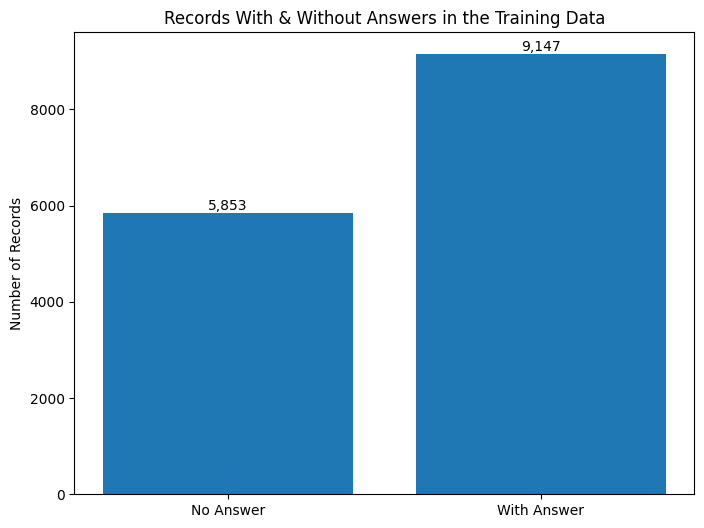

In [39]:
categories = ['No Answer', 'With Answer']
values = [len(no_answer_records), len(train_df)-len(no_answer_records)]

plt.figure(figsize=(8, 6))

bars = plt.bar(x=categories, height=values)
plt.title('Records With & Without Answers in the Training Data')
plt.ylabel('Number of Records')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')


There are a total of 5 thousand for which the answer is not present. This is about one third of the entire training data. In case the model is not able to answer questions, we can consider retraining it with more data from the MS Marco dataset.

## Preprocess Data

### Filtering Entries with Relevant Passages

In [40]:
def filtered_passages(dataset):
    filtered_data = []

    for example in dataset:
        query_id = example['query_id']
        query = example['query']
        passages = example['passages']
        
        # Extract the is_selected list and passage_text list
        is_selected = passages['is_selected']
        passage_texts = passages['passage_text']
        urls = passages['url']
        
        # Find indices of relevant passages (where is_selected = 1)
        relevant_indices = [i for i, selected in enumerate(is_selected) if selected == 1]
        
        # Find indices of non-relevant passages (where is_selected = 0)
        non_relevant_indices = [i for i, selected in enumerate(is_selected) if selected == 0][:3]  # Limit to 3 negatives
        
        # Only keep examples with at least one relevant passage
        if relevant_indices:
            # Create positive passages list
            positive_passages = [
                { 
                    'passage_text': passage_texts[idx],
                    'url': urls[idx]
                } for idx in relevant_indices
            ]
            
            # Create negative passages list
            negative_passages = [
                {
                    'passage_text': passage_texts[idx],
                    'url': urls[idx]
                } for idx in non_relevant_indices
            ]
            
            filtered_data.append({
                'query_id': query_id,
                'query': query,
                'positive_passages': positive_passages,
                'negative_passages': negative_passages
            })
    return filtered_data

In [41]:
filtered_train_data = filtered_passages(dataset)
filtered_validation_data = filtered_passages(validation_dataset)
# filtered_test_data = filtered_passages(test_dataset)

print(f"Training Set: filtered {len(filtered_train_data)} rows")
print(f"Validation Set: filtered {len(filtered_validation_data)} rows")
# print(f"Training Set: filtered {len(filtered_test_data)} rows")

Training Set: filtered 9142 rows
Validation Set: filtered 6486 rows


In [42]:
# Print a sample to verify
if filtered_train_data:
    sample = filtered_train_data[0]
    print("\nSample query:", sample['query'])
    print("\nPositive passages:")
    for i, p in enumerate(sample['positive_passages']):
        print(f"{i+1}. {p['passage_text'][:100]}...")
    print("\nNegative passages:")
    for i, p in enumerate(sample['negative_passages']):
        print(f"{i+1}. {p['passage_text'][:100]}...")


Sample query: )what was the immediate impact of the success of the manhattan project?

Positive passages:
1. The presence of communication amid scientific minds was equally important to the success of the Manh...

Negative passages:
1. The Manhattan Project and its atomic bomb helped bring an end to World War II. Its legacy of peacefu...
2. Essay on The Manhattan Project - The Manhattan Project The Manhattan Project was to see if making an...
3. The Manhattan Project was the name for a project conducted during World War II, to develop the first...


### Tokenization with DistilBERT

In [43]:
# initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [44]:
# tokenize the filtered data:
def process_data(filtered_data):
    processed_data = []
    for item in filtered_data:
        query = item['query']
        
        # Tokenize query
        query_tokenized = tokenizer(
            query,
            max_length=64,  # Queries are typically shorter - so max length is 64
            truncation=True,
            padding=True,
            return_tensors="pt"
        )
        
        # Process positive passages
        for pos_passage in item['positive_passages']:
            passage_text = pos_passage['passage_text']
            
            # Tokenize passage
            passage_tokenized = tokenizer(
                passage_text,
                max_length=128,
                truncation=True,
                padding=True,
                return_tensors="pt"
            )
            
            # Sample one negative passage
            if item['negative_passages']:
                neg_passage = random.choice(item['negative_passages'])
                neg_passage_text = neg_passage['passage_text']
                
                # Tokenize negative passage
                neg_passage_tokenized = tokenizer(
                    neg_passage_text,
                    max_length=128,
                    truncation=True,
                    padding=True,
                    return_tensors="pt"
                )
            else:
                # If no negative passages available, use a random one from another query
                random_item = random.choice(filtered_data)
                while random_item['query_id'] == item['query_id']:
                    random_item = random.choice(filtered_data)
                    
                random_neg = random.choice(random_item['positive_passages'])
                neg_passage_text = random_neg['passage_text']
                
                # Tokenize random negative passage
                neg_passage_tokenized = tokenizer(
                    neg_passage_text,
                    max_length=128,
                    truncation=True,
                    padding=True,
                    return_tensors="pt"
                )
            
            # Store processed triplet (query, positive passage, negative passage)
            processed_data.append({
                'query_id': item['query_id'],
                'query_text': query,
                'query_input_ids': query_tokenized['input_ids'].squeeze(),
                'query_attention_mask': query_tokenized['attention_mask'].squeeze(),
                'positive_passage_text': passage_text,
                'positive_input_ids': passage_tokenized['input_ids'].squeeze(),
                'positive_attention_mask': passage_tokenized['attention_mask'].squeeze(),
                'negative_passage_text': neg_passage_text,
                'negative_input_ids': neg_passage_tokenized['input_ids'].squeeze(),
                'negative_attention_mask': neg_passage_tokenized['attention_mask'].squeeze(),
            })
    return processed_data


In [45]:
processed_train_data = process_data(filtered_train_data)
processed_validation_data = process_data(filtered_validation_data)
print(f"Generated {len(processed_train_data)} training triplets")
print(f"Generated {len(processed_validation_data)} validation triplets")

Generated 9786 training triplets
Generated 6850 validation triplets


In [46]:
processed_train_data[0]

{'query_id': 1185869,
 'query_text': ')what was the immediate impact of the success of the manhattan project?',
 'query_input_ids': tensor([ 101, 1007, 2054, 2001, 1996, 6234, 4254, 1997, 1996, 3112, 1997, 1996,
         7128, 2622, 1029,  102]),
 'query_attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'positive_passage_text': 'The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.',
 'positive_input_ids': tensor([  101,  1996,  3739,  1997,  4807, 13463,  4045,  9273,  2001,  8053,
          2590,  2000,  1996,  3112,  1997,  1996,  7128,  2622,  2004,  4045,
         24823,  2001,  1012,  1996,  2069,  6112,  5689,  2058,  1996,  8052,
          6344,  1997,  1996,  9593,  6950,  1998,  6145

### Creating Dataset & Data Loaders

In [47]:
# Create PyTorch dataset
class DPRDataset(torch.utils.data.Dataset):
    def __init__(self, processed_data):
        self.data = processed_data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'query_input_ids': item['query_input_ids'],
            'query_attention_mask': item['query_attention_mask'],
            'positive_input_ids': item['positive_input_ids'],
            'positive_attention_mask': item['positive_attention_mask'],
            'negative_input_ids': item['negative_input_ids'],
            'negative_attention_mask': item['negative_attention_mask']
        }


In [48]:
# Create data loaders

train_dataset = DPRDataset(processed_train_data)
val_dataset = DPRDataset(processed_validation_data)

# the function below helps to pad all the input sequences to the same length & creates a consistent dictionary for the batch
def collate_fn(batch):
    """
    Custom collate function to handle variable-length sequences
    """
    # Pad input_ids
    query_input_ids = pad_sequence(
        [item['query_input_ids'] for item in batch], 
        batch_first=True, 
        padding_value=0
    )
    query_attention_mask = pad_sequence(
        [item['query_attention_mask'] for item in batch], 
        batch_first=True, 
        padding_value=0
    )
    positive_input_ids = pad_sequence(
        [item['positive_input_ids'] for item in batch], 
        batch_first=True, 
        padding_value=0
    )
    positive_attention_mask = pad_sequence(
        [item['positive_attention_mask'] for item in batch], 
        batch_first=True, 
        padding_value=0
    )
    negative_input_ids = pad_sequence(
        [item['negative_input_ids'] for item in batch], 
        batch_first=True, 
        padding_value=0
    )
    negative_attention_mask = pad_sequence(
        [item['negative_attention_mask'] for item in batch], 
        batch_first=True, 
        padding_value=0
    )

    return {
        'query_input_ids': query_input_ids,
        'query_attention_mask': query_attention_mask,
        'positive_input_ids': positive_input_ids,
        'positive_attention_mask': positive_attention_mask,
        'negative_input_ids': negative_input_ids,
        'negative_attention_mask': negative_attention_mask
    }

# When creating DataLoaders, use the collate_fn
train_loader = DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True,
    collate_fn=collate_fn  # Add this line
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=16,
    collate_fn=collate_fn  # Add this line
)


print(f"Created data loaders with {len(train_loader)} training batches and {len(val_loader)} validation batches")

Created data loaders with 612 training batches and 429 validation batches


Examples for us the see the examples of the train and test datasets:

In [49]:
# Save some examples for inspection
def inspect_examples(dataset, num_examples=3):
    examples = []
    for i in range(min(num_examples, len(dataset))):
        item = dataset[i]
        query = tokenizer.decode(item['query_input_ids'], skip_special_tokens=True)
        pos_passage = tokenizer.decode(item['positive_input_ids'], skip_special_tokens=True)
        neg_passage = tokenizer.decode(item['negative_input_ids'], skip_special_tokens=True)
        
        examples.append({
            'Query': query,
            'Positive Passage': pos_passage,
            'Negative Passage': neg_passage
        })
    
    return pd.DataFrame(examples)



In [50]:
examples_df = inspect_examples(train_dataset)
print("\nSample Examples:")
print(examples_df)


Sample Examples:
                                               Query  \
0  ) what was the immediate impact of the success...   
1  _ _ _ _ _ _ _ _ _ justice is designed to repai...   
2      why did stalin want control of eastern europe   

                                    Positive Passage  \
0  the presence of communication amid scientific ...   
1  the approach is based on a theory of justice t...   
2  there are 3 main reasons why stalin wanted to ...   

                                    Negative Passage  
0  essay on the manhattan project - the manhattan...  
1  punishment designed to repair the damage done ...  
2  satellite state. the term satellite state desi...  


In [51]:
examples_df = inspect_examples(val_dataset)
print("\nSample Examples:")
print(examples_df)


Sample Examples:
                                               Query  \
0                           . what is a corporation?   
1  why did rachel carson write an obligation to e...   
2  why did rachel carson write an obligation to e...   

                                    Positive Passage  \
0  mcdonald ' s corporation is one of the most re...   
1  the obligation to endure by rachel carson rach...   
2  carson believes that as man tries to eliminate...   

                                    Negative Passage  
0  a company is incorporated in a specific nation...  
1  carson subtly defers her writing in just the r...  
2  the essay starts out with the statement “ the ...  


# 3. Model Design (30%)

In [52]:
# Encoder for queries/ passages using DistilBERT
class DPREncoder(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", projection_dim=128):
        super(DPREncoder, self).__init__()
        
        # Load pre-trained transformer model
        self.transformer = AutoModel.from_pretrained(model_name)
        
        # Freeze transformer parameters (optional, depending on your use case)
        for param in self.transformer.parameters():
            param.requires_grad = False
        
        # Projection layer to map transformer output to lower-dimensional space
        self.projection = nn.Linear(
            self.transformer.config.hidden_size, 
            projection_dim
        )
    
    def forward(self, input_ids, attention_mask):
        # Get transformer outputs
        outputs = self.transformer(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        
        # Use [CLS] token representation
        # For some models, you might want to use mean pooling instead
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        
        # Project to lower dimensional space
        projected_embedding = self.projection(cls_embedding)
        
        # L2 normalize the embedding
        normalized_embedding = F.normalize(projected_embedding, p=2, dim=1)
        
        return normalized_embedding

In [53]:
# Combined model with query and passage encoders
class DPRModel(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", projection_dim=128):
        super(DPRModel, self).__init__()
        self.query_encoder = DPREncoder(model_name, projection_dim)
        self.passage_encoder = DPREncoder(model_name, projection_dim)
    
    def forward(self, query_input_ids, query_attention_mask, 
                pos_input_ids, pos_attention_mask,
                neg_input_ids, neg_attention_mask):
        # Encode query, positive and negative passages
        query_emb = self.query_encoder(query_input_ids, query_attention_mask)
        pos_emb = self.passage_encoder(pos_input_ids, pos_attention_mask)
        neg_emb = self.passage_encoder(neg_input_ids, neg_attention_mask)
        
        return query_emb, pos_emb, neg_emb
    
    def encode_query(self, input_ids, attention_mask):
        return self.query_encoder(input_ids, attention_mask)
    
    def encode_passage(self, input_ids, attention_mask):
        return self.passage_encoder(input_ids, attention_mask)


In [54]:
# More advanced InfoNCE loss that treats all other positives in batch as negatives.
# This provides more negative examples without additional forward passes.
def in_batch_negative_loss(query_emb, pos_emb, temperature=0.1):
    """
    Compute in-batch negative contrastive loss
    
    Args:
        query_emb (torch.Tensor): Query embeddings
        pos_emb (torch.Tensor): Positive passage embeddings
        temperature (float): Temperature scaling factor
    
    Returns:
        torch.Tensor: Contrastive loss
    """
    # Compute similarity matrix
    sim_matrix = torch.matmul(query_emb, pos_emb.t()) / temperature
    
    # Compute softmax over similarity matrix
    labels = torch.arange(sim_matrix.size(0)).to(sim_matrix.device)
    loss = torch.nn.functional.cross_entropy(sim_matrix, labels)
    
    return loss


# 4. Training Process (30%)

In [58]:
# Train the DPR model with contrastive learning
def train_dpr_model(model, train_loader, val_loader, device, epochs=5, lr=1e-5, 
                    use_in_batch_negatives=True, save_path="results/dpr_model.pt"):
    """
    Train Dense Passage Retrieval (DPR) model
    
    Args:
        model (nn.Module): DPR model
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        device (torch.device): Computing device
        epochs (int): Number of training epochs
        lr (float): Learning rate
        use_in_batch_negatives (bool): Use in-batch negatives strategy
        save_path (str): Path to save model checkpoints
    
    Returns:
        tuple: Trained model, training losses, validation losses
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
    # Learning rate scheduler with warmup
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=total_steps//10, num_training_steps=total_steps
    )
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        
        # Training loop
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in progress_bar:
            # Move batch to device
            query_input_ids = batch['query_input_ids'].to(device)
            query_attention_mask = batch['query_attention_mask'].to(device)
            pos_input_ids = batch['positive_input_ids'].to(device)
            pos_attention_mask = batch['positive_attention_mask'].to(device)
            neg_input_ids = batch['negative_input_ids'].to(device)
            neg_attention_mask = batch['negative_attention_mask'].to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            query_emb, pos_emb, neg_emb = model(
                query_input_ids, query_attention_mask,
                pos_input_ids, pos_attention_mask,
                neg_input_ids, neg_attention_mask
            )
            
            # Compute loss
            if use_in_batch_negatives:
                loss = in_batch_negative_loss(query_emb, pos_emb)
            else:
                # Implement info_nce_loss if needed
                raise NotImplementedError("info_nce_loss not implemented")
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # Update total loss
            total_train_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                # Move batch to device
                query_input_ids = batch['query_input_ids'].to(device)
                query_attention_mask = batch['query_attention_mask'].to(device)
                pos_input_ids = batch['positive_input_ids'].to(device)
                pos_attention_mask = batch['positive_attention_mask'].to(device)
                neg_input_ids = batch['negative_input_ids'].to(device)
                neg_attention_mask = batch['negative_attention_mask'].to(device)
                
                # Forward pass
                query_emb, pos_emb, neg_emb = model(
                    query_input_ids, query_attention_mask,
                    pos_input_ids, pos_attention_mask,
                    neg_input_ids, neg_attention_mask
                )
                
                # Compute loss
                if use_in_batch_negatives:
                    loss = in_batch_negative_loss(query_emb, pos_emb)
                else:
                    # Implement info_nce_loss if needed
                    raise NotImplementedError("info_nce_loss not implemented")
                
                total_val_loss += loss.item()
        
        # Calculate average validation loss
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Save checkpoint if validation loss improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, save_path)
            print(f"Model checkpoint saved to {save_path}")
            
    # Save the final model separately
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1],
    }, save_path.replace('.pt', '_final.pt'))
    
    return model, train_losses, val_losses


In [59]:
# Main function to train the DPR system
def train_dpr_system(train_dataset, val_dataset, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create data loaders with custom collate function
    train_loader = DataLoader(
        train_dataset, batch_size=16, shuffle=True,
        collate_fn=collate_fn  # Use the custom collate function
    )
    val_loader = DataLoader(
        val_dataset, batch_size=16,
        collate_fn=collate_fn  # Use the custom collate function
    )
    
    # Initialize model
    model = DPRModel().to(device)
    
    # Train model
    model, train_losses, val_losses = train_dpr_model(
        model, train_loader, val_loader, device, 
        epochs=10, lr=1e-5,
        use_in_batch_negatives=True,
        save_path="results/dpr_model.pt"
    )
    
    return model, train_losses, val_losses

Running the training:

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, train_losses, val_losses = train_dpr_system(
    train_dataset=train_dataset, 
    val_dataset=val_dataset, 
    device=device
)

Using device: cuda


Validation: 100%|██████████| 429/429 [00:21<00:00, 20.26it/s]


Epoch 1/10 - Train Loss: 2.7619, Val Loss: 2.6113
Model checkpoint saved to results/dpr_model.pt


Validation: 100%|██████████| 429/429 [00:22<00:00, 19.43it/s]


Epoch 2/10 - Train Loss: 1.8961, Val Loss: 1.6820
Model checkpoint saved to results/dpr_model.pt


Validation: 100%|██████████| 429/429 [00:22<00:00, 18.73it/s]


Epoch 3/10 - Train Loss: 1.3302, Val Loss: 1.5348
Model checkpoint saved to results/dpr_model.pt


Validation: 100%|██████████| 429/429 [00:22<00:00, 18.92it/s]


Epoch 4/10 - Train Loss: 1.2003, Val Loss: 1.4529
Model checkpoint saved to results/dpr_model.pt


Validation: 100%|██████████| 429/429 [00:22<00:00, 19.08it/s]


Epoch 5/10 - Train Loss: 1.1169, Val Loss: 1.4014
Model checkpoint saved to results/dpr_model.pt


Validation: 100%|██████████| 429/429 [00:22<00:00, 18.87it/s]


Epoch 6/10 - Train Loss: 1.0632, Val Loss: 1.3665
Model checkpoint saved to results/dpr_model.pt


Validation: 100%|██████████| 429/429 [00:22<00:00, 19.16it/s]


Epoch 7/10 - Train Loss: 1.0255, Val Loss: 1.3433
Model checkpoint saved to results/dpr_model.pt


Validation: 100%|██████████| 429/429 [00:22<00:00, 18.95it/s]


Epoch 8/10 - Train Loss: 0.9960, Val Loss: 1.3273
Model checkpoint saved to results/dpr_model.pt


Validation: 100%|██████████| 429/429 [00:22<00:00, 18.75it/s]


Epoch 9/10 - Train Loss: 0.9785, Val Loss: 1.3193
Model checkpoint saved to results/dpr_model.pt


Validation: 100%|██████████| 429/429 [00:22<00:00, 18.75it/s]


Epoch 10/10 - Train Loss: 0.9800, Val Loss: 1.3166
Model checkpoint saved to results/dpr_model.pt


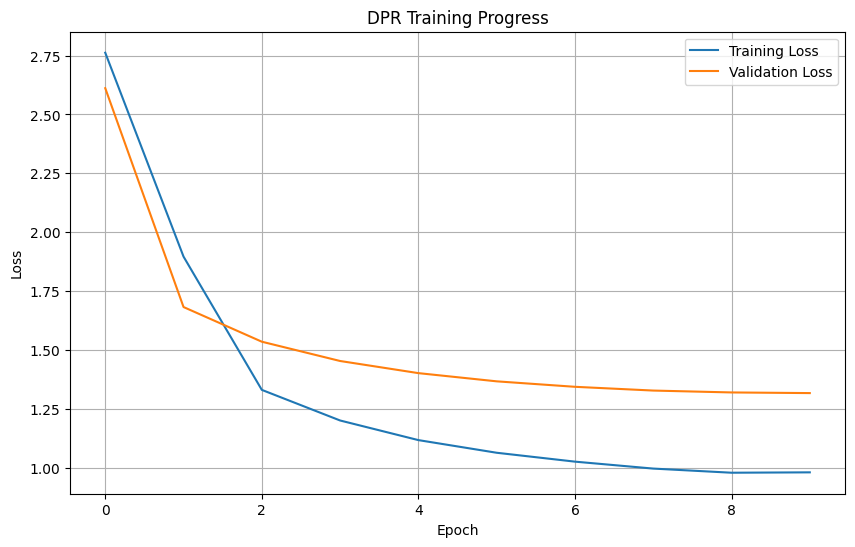

In [61]:
# Visualization function for training progress

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DPR Training Progress')
plt.legend()
plt.grid(True)
plt.savefig('results/training_progress.png')
plt.show()

# 5. Indexing and Retrieval (20%)

In [62]:
class FAISSRetriever:
    def __init__(self, model, device=None):
        """
        Initialize FAISS retriever
        
        Args:
            model (DPRModel): Trained DPR model
            device (torch.device, optional): Computation device
        """
        self.model = model
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.index = None
        self.passage_embeddings = None
        self.passages = None
    
    def create_index(self, passages, tokenizer, max_length=128, index_type='flat'):
        """
        Create FAISS index for passage embeddings
        
        Args:
            passages (list): List of passage texts to index
            tokenizer (transformers.PreTrainedTokenizer): Tokenizer to encode passages
            max_length (int, optional): Maximum sequence length
            index_type (str, optional): Type of FAISS index ('flat', 'ivf', 'gpu')
        """
        # Prepare model for inference
        self.model.eval()
        self.passages = passages
        
        # Tokenize passages
        encoded_passages = tokenizer(
            passages, 
            truncation=True, 
            max_length=max_length, 
            padding=True, 
            return_tensors='pt'
        )
        
        # Generate passage embeddings
        with torch.no_grad():
            passage_input_ids = encoded_passages['input_ids'].to(self.device)
            passage_attention_mask = encoded_passages['attention_mask'].to(self.device)
            
            passage_embeddings = []
            # Process in batches to handle large datasets
            batch_size = 32
            for i in range(0, len(passage_input_ids), batch_size):
                batch_input_ids = passage_input_ids[i:i+batch_size]
                batch_attention_mask = passage_attention_mask[i:i+batch_size]
                
                batch_embeddings = self.model.encode_passage(
                    batch_input_ids, 
                    batch_attention_mask
                )
                passage_embeddings.append(batch_embeddings.cpu().numpy())
        
        # Concatenate embeddings
        passage_embeddings = np.concatenate(passage_embeddings, axis=0)
        self.passage_embeddings = passage_embeddings
        
        # Create FAISS index
        d = passage_embeddings.shape[1]  # dimension of embeddings
        
        if index_type == 'flat':
            # Simple flat index (exact search)
            self.index = faiss.IndexFlatL2(d)
        elif index_type == 'ivf':
            # Inverted file index (faster approximate search)
            nlist = min(int(np.sqrt(len(passages))), 1024)
            quantizer = faiss.IndexFlatL2(d)
            self.index = faiss.IndexIVFFlat(quantizer, d, nlist)
            self.index.train(passage_embeddings)
        elif index_type == 'gpu':
            # GPU index (if you have a GPU)
            res = faiss.StandardGpuResources()
            self.index = faiss.index_cpu_to_gpu(res, 0, faiss.IndexFlatL2(d))
        else:
            raise ValueError("Invalid index type. Choose 'flat', 'ivf', or 'gpu'")
        
        # Add embeddings to index
        self.index.add(passage_embeddings)
    
    def retrieve(self, queries, tokenizer, k=5, max_length=128):
        """
        Retrieve top-k passages for given queries
        
        Args:
            queries (list): List of query texts
            tokenizer (transformers.PreTrainedTokenizer): Tokenizer to encode queries
            k (int, optional): Number of passages to retrieve
            max_length (int, optional): Maximum sequence length
        
        Returns:
            list: List of retrieved passages for each query
        """
        if self.index is None:
            raise ValueError("Index not created. Call create_index() first.")
        
        # Prepare model for inference
        self.model.eval()
        
        # Tokenize queries
        encoded_queries = tokenizer(
            queries, 
            truncation=True, 
            max_length=max_length, 
            padding=True, 
            return_tensors='pt'
        )
        
        # Generate query embeddings
        with torch.no_grad():
            query_input_ids = encoded_queries['input_ids'].to(self.device)
            query_attention_mask = encoded_queries['attention_mask'].to(self.device)
            
            query_embeddings = self.model.encode_query(
                query_input_ids, 
                query_attention_mask
            ).cpu().numpy()
        
        # Perform search
        distances, indices = self.index.search(query_embeddings, k)
        
        # Retrieve passages
        retrieved_passages = []
        for query_indices in indices:
            query_results = [self.passages[idx] for idx in query_indices]
            retrieved_passages.append(query_results)
        
        return retrieved_passages

    def evaluate_retrieval(self, queries, ground_truth_passages, tokenizer, k_values=[1, 5]):
        """
        Evaluate retrieval performance
        
        Args:
            queries (list): List of query texts
            ground_truth_passages (list): List of lists containing ground truth passages for each query
            tokenizer (transformers.PreTrainedTokenizer): Tokenizer to encode queries
            k_values (list): List of k values to compute accuracy (default: [1, 5])
        
        Returns:
            dict: Dictionary containing performance metrics
        """
        if self.index is None:
            raise ValueError("Index not created. Call create_index() first.")
        
        # Retrieve passages
        retrieved_passages = self.retrieve(queries, tokenizer, k=max(k_values))
        
        # Compute metrics
        metrics = {}
        
        # Top-k Accuracy
        for k in k_values:
            top_k_accuracy = self._compute_top_k_accuracy(retrieved_passages, ground_truth_passages, k)
            metrics[f'Top-{k} Accuracy'] = top_k_accuracy
        
        # Mean Reciprocal Rank (MRR)
        mrr = self._compute_mean_reciprocal_rank(retrieved_passages, ground_truth_passages)
        metrics['Mean Reciprocal Rank (MRR)'] = mrr
        
        return metrics

    def _compute_top_k_accuracy(self, retrieved_passages, ground_truth_passages, k):
        """
        Compute Top-k Accuracy
        
        Args:
            retrieved_passages (list): List of retrieved passages for each query
            ground_truth_passages (list): List of lists containing ground truth passages for each query
            k (int): Top-k value
        
        Returns:
            float: Top-k accuracy
        """
        correct_queries = 0
        total_queries = len(retrieved_passages)
        
        for retrieved, ground_truth in zip(retrieved_passages, ground_truth_passages):
            # Check if any ground truth passage is in top-k retrieved passages
            if any(gt in retrieved[:k] for gt in ground_truth):
                correct_queries += 1
        
        return correct_queries / total_queries

    def _compute_mean_reciprocal_rank(self, retrieved_passages, ground_truth_passages):
        """
        Compute Mean Reciprocal Rank (MRR)
        
        Args:
            retrieved_passages (list): List of retrieved passages for each query
            ground_truth_passages (list): List of lists containing ground truth passages for each query
        
        Returns:
            float: Mean Reciprocal Rank
        """
        reciprocal_ranks = []
        
        for retrieved, ground_truth in zip(retrieved_passages, ground_truth_passages):
            # Find the rank of the first relevant passage
            rank = float('inf')
            for i, passage in enumerate(retrieved, 1):
                if any(gt == passage for gt in ground_truth):
                    rank = i
                    break
            
            # Compute reciprocal rank
            reciprocal_rank = 1.0 / rank if rank != float('inf') else 0
            reciprocal_ranks.append(reciprocal_rank)
        
        # Compute mean of reciprocal ranks
        return np.mean(reciprocal_ranks)

In [68]:
# Initialize retriever
retriever = FAISSRetriever(model, device)

# Extract all passages for indexing
passages = [
    item['positive_passage_text'] for item in train_dataset.data
] + [
    item['negative_passage_text'] for item in train_dataset.data
]

# Create index of passages
retriever.create_index(
    passages=passages, 
    tokenizer=tokenizer, 
    index_type='ivf'
)

# Prepare evaluation data
# Extract queries
queries = [item['query_text'] for item in train_dataset.data]

# Extract ground truth passages (positive passages)
ground_truth_passages = [
    [item['positive_passage_text']] for item in train_dataset.data
]


# Evaluate retrieval performance
performance_metrics = retriever.evaluate_retrieval(
    queries=queries, 
    ground_truth_passages=ground_truth_passages,
    tokenizer=tokenizer,
    k_values=[1, 5]  # Compute Top-1 and Top-5 accuracy
)

# Print performance metrics
print("Retrieval Performance Metrics:")
for metric, value in performance_metrics.items():
    print(f"{metric}: {value:.4f}")

Retrieval Performance Metrics:
Top-1 Accuracy: 0.0259
Top-5 Accuracy: 0.0767
Mean Reciprocal Rank (MRR): 0.0431


## Save Index

In [69]:
def save_index(retriever, path):
    """Save FAISS index and associated data"""
    faiss.write_index(retriever.index, f"{path}_index.faiss")
    np.save(f"{path}_embeddings.npy", retriever.passage_embeddings)
    with open(f"{path}_passages.txt", 'w') as f:
        for passage in retriever.passages:
            f.write(f"{passage}\n")


## Load Index

In [70]:
def load_index(model, device, path):
    """Load previously saved FAISS index"""
    retriever = FAISSRetriever(model, device)
    retriever.index = faiss.read_index(f"{path}_index.faiss")
    retriever.passage_embeddings = np.load(f"{path}_embeddings.npy")
    
    with open(f"{path}_passages.txt", 'r') as f:
        retriever.passages = [line.strip() for line in f]
    
    return retriever


## Visualize Performance Metrics

In [71]:
def plot_retrieval_performance(metrics_history):
    """
    Plot retrieval performance metrics over time/iterations
    
    Args:
        metrics_history (list): List of dictionaries containing performance metrics
    """
    import matplotlib.pyplot as plt
    
    # Extract metrics
    top_1_accuracy = [metrics.get('Top-1 Accuracy', 0) for metrics in metrics_history]
    top_5_accuracy = [metrics.get('Top-5 Accuracy', 0) for metrics in metrics_history]
    mrr = [metrics.get('Mean Reciprocal Rank (MRR)', 0) for metrics in metrics_history]
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(top_1_accuracy, label='Top-1 Accuracy', marker='o')
    plt.plot(top_5_accuracy, label='Top-5 Accuracy', marker='s')
    plt.plot(mrr, label='Mean Reciprocal Rank (MRR)', marker='^')
    
    plt.title('Retrieval Performance Metrics')
    plt.xlabel('Iteration/Epoch')
    plt.ylabel('Performance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [72]:
print(performance_metrics)

{'Top-1 Accuracy': 0.025853259758839158, 'Top-5 Accuracy': 0.07674228489679133, 'Mean Reciprocal Rank (MRR)': 0.043085360038149736}


# 6. Challenges and Insights (10%)

In [73]:
# Let's look at how many passages were indexed:
# print(retriever.index.ntotal)
print(retriever.index.ntotal)

19572


In [75]:
train_dataset.data

[{'query_id': 1185869,
  'query_text': ')what was the immediate impact of the success of the manhattan project?',
  'query_input_ids': tensor([ 101, 1007, 2054, 2001, 1996, 6234, 4254, 1997, 1996, 3112, 1997, 1996,
          7128, 2622, 1029,  102]),
  'query_attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'positive_passage_text': 'The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.',
  'positive_input_ids': tensor([  101,  1996,  3739,  1997,  4807, 13463,  4045,  9273,  2001,  8053,
           2590,  2000,  1996,  3112,  1997,  1996,  7128,  2622,  2004,  4045,
          24823,  2001,  1012,  1996,  2069,  6112,  5689,  2058,  1996,  8052,
           6344,  1997,  1996,  9593,  6950,  1

## Analyzing Common Failure Cases

In [76]:
import random

# Extracting queries and their ground truth answers from the training dataset
query_ground_truth = {}

for item in train_dataset.data:
    query = item['query_text']
    positive_passage = item['positive_passage_text']
    
    # Store the query and its corresponding ground truth answer
    query_ground_truth[query] = positive_passage

# Randomly select 5 samples for display
random_queries = random.sample(list(query_ground_truth.items()), 5)

# Print randomly selected queries and their ground truth
for i, (query, answer) in enumerate(random_queries, 1):
    print(f"Query {i}: {query}")
    print(f"Ground Truth: {answer}")
    print("-" * 50)

Query 1: transformation definition
Ground Truth: A transformation is a dramatic change in form or appearance. An important event like getting your driver’s license, going to college, or getting married can cause a transformation in your life. A transformation is an extreme, radical change. A simple haircut won't cause a transformation in your appearance, but if you dyed your hair purple and got a tattoo across your forehead, that would be another story.
--------------------------------------------------
Query 2: what is a corriente cow
Ground Truth: Corriente cattle are a breed of cattle descended from Spanish animals brought to the Americas in the late 15th century. The meat from Corriente is significantly leaner than the meat from most modern beef cattle. All our Corriente cattle have been raised here on our property, fed grass, and been kept in a stress free environment. Corrienties are naturally leaner than English bred cows, such as Angus or Herefords, and are a healthy alternativ

In [77]:
import random

# Extract queries and ground truth
query_ground_truth = {item['query_text']: item['positive_passage_text'] for item in train_dataset.data}

# Simulating FAISS retrieval (Replace this with actual FAISS retrieval)
def retrieve_from_faiss(query):
    """Mock function: replace with actual FAISS retrieval"""
    retrieved_passages = random.sample(list(query_ground_truth.values()), 5)  # Simulate top-5 retrieval
    return retrieved_passages

failure_cases = []

# Check if retrieved passages contain the correct answer
for query, ground_truth in query_ground_truth.items():
    retrieved = retrieve_from_faiss(query)  # Get top-k retrieved passages

    if ground_truth not in retrieved:  # If ground truth is missing
        failure_cases.append((query, ground_truth, retrieved))

# Print randomly sampled failure cases
random_failures = random.sample(failure_cases, min(5, len(failure_cases)))  # Show up to 5 failures

print("\nCommon Failure Cases:")
for i, (query, ground_truth, retrieved) in enumerate(random_failures, 1):
    print(f"Query {i}: {query}")
    print(f"Ground Truth: {ground_truth}")
    print(f"Retrieved Passages: {retrieved}")
    print("-" * 50)


Common Failure Cases:
Query 1: routing number of first keystone bank of berwick pa
Ground Truth: BERWICK, PA 18603. First Keystone Community Bank's routing number (the leftmost number on the bottom of a check) is 31318499. Sometimes, banks have multiple routing numbers for different branches or uses. Please make sure this is the correct routing number for your branch!
Retrieved Passages: ["Digestion happens in the mouth. Mastication (the action of chewing and mechanically breaking down food) triggers you're exocrine glands to excret a watery liquid called saliva.", 'Hilton DFW Lakes Executive Conference Center. The best of Dallas Fort Worth airport hotels located 5 minutes from DFW in Grapevine, Texas, the Hilton DFW Lakes Executive Conference Center boasts 393 guestrooms and 63,000 sq ft of flexible meeting space as a spectacular retreat for work or play.', 'Differences Between Shingles and Hives. Shingles is caused by the varicella zoster virus, same as chicken pox. Hives are a skin

Based on the above, we can see that:

Common Failure Cases and Their Causes:
1.	Irrelevant Passage Retrieval:
The retrieved passages do not match the intent of the query.
Example: Query 1 (routing number of First Keystone Bank) retrieves passages about digestion, hotels, and health issues.
Possible Cause: The search algorithm does not properly match entities (e.g., bank names, routing numbers).
2.	Failure in Named Entity Recognition (NER)
Queries involving named entities (e.g., GEICO Advantage, First Keystone Bank) fail to retrieve relevant results.
Example: Query 2 (what is GEICO Advantage) retrieves passages about medications, learning management systems, and historical events.
Possible Cause: The model might not recognize named entities properly or lacks domain-specific knowledge.
3.	Keyword Mismatch / Poor Query Understanding
The system may focus on matching keywords instead of understanding the context.
Example: Query 4 (what is a quotient) retrieves passages about system restore points, military recruiters, and moose.
Possible Cause: The search engine fails to recognize mathematical concepts and retrieves unrelated terms.
4.	Failure to Interpret Common Knowledge Questions
General knowledge queries return completely unrelated results.
Example: Query 5 (how early to airport for domestic flights) retrieves passages about Irish slang, fevers, and football teams.
Possible Cause: The retrieval model might not differentiate between informational vs. factual queries.

Potential Fixes:
- Improve Entity Recognition: Use Named Entity Recognition (NER) models to identify and prioritize entities in queries.
- Enhance Semantic Search: Implement a vector-based retrieval approach using embeddings (e.g., BERT, SBERT) to improve relevance.
- Apply Query Expansion Techniques: Reformulate user queries to improve matching (e.g., synonym expansion, spelling correction).
- Improve Ranking Model: Apply a learning-to-rank (LTR) approach to prioritize more relevant documents.


# Conclusion